In [13]:
from __future__ import print_function
from itertools import combinations, permutations
import logging
import networkx as nx
import numpy as np
import scipy.stats as sps
import scipy.special as spsp

from sklearn.linear_model import LinearRegression
import time
import pandas as pd
from random import random
from collections import defaultdict
from sklearn import metrics
import os
import matplotlib.pyplot as plt
# from chowLiuUtilities import *

%matplotlib inline

_logger = logging.getLogger(__name__)

In [14]:
def _create_complete_graph(node_ids):
    """Create a complete graph from the list of node ids.

    Args:
        node_ids: a list of node ids

    Returns:
        An undirected graph (as a networkx.Graph)
    """
    g = nx.Graph()
    g.add_nodes_from(node_ids)
    for (i, j) in combinations(node_ids, 2):
        g.add_edge(i, j)
    return g

In [66]:
def estimate_skeleton_prior(indep_test_func, corr_matrix, sample_size, alpha, reverse, **kwargs):
    def method_stable(kwargs):
        return ('method' in kwargs) and kwargs['method'] == "stable"

    node_ids = range(corr_matrix.shape[0])
    node_size = corr_matrix.shape[0]

    g = _create_complete_graph(node_ids)

    for l in reversed(range(node_size-1)):
        print(f"==================> Performing round {l} .....")
        # del_num = 0
        cont = False
        remove_edges = []
        for (i, j) in permutations(node_ids, 2):
            #print(f"Test edge {i, j}")
            adj_i = list(g.neighbors(i))
            if j not in adj_i:
                continue
            else:
                adj_i.remove(j)
            if len(adj_i) >= l:

                if len(adj_i) < l:
                    continue

                for k in combinations(adj_i, l):
                    # print(f"Test edge {i, j} on {k}")
                    z_val = indep_test_func(corr_matrix, i, j, list(set(k)),
                                            **kwargs)
                    tau = sps.norm.ppf(1-alpha/2)/np.sqrt(sample_size - l - 3) 
                    # print(f"z is {z_val} and tau is {tau}")
                    if np.abs(z_val) <= tau:
                        if g.has_edge(i, j):
                            if method_stable(kwargs):
                                remove_edges.append((i, j))
                                # print("remove edge {}-{} based on {}".format(i, j, k) )
                            else:
                                g.remove_edge(i, j)
                                # print("remove edge {}-{} based on {}".format(i, j, k) )
                        # del_num += 1
                        break
                cont = True
                
        if method_stable(kwargs):
            g.remove_edges_from(remove_edges)
            #print(f"Remove edges: {remove_edges}")
        if cont is False:
            break
        if ('max_reach' in kwargs) and (l > kwargs['max_reach']):
            break

    return g

In [84]:
def estimate_skeleton(indep_test_func, corr_matrix, sample_size, alpha, priority, **kwargs):
    def method_stable(kwargs):
        return ('method' in kwargs) and kwargs['method'] == "stable"

    node_ids = range(corr_matrix.shape[0])
    node_size = corr_matrix.shape[0]
    sep_set = [[set() for i in range(node_size)] for j in range(node_size)]
    
    if 'init_graph' in kwargs:
        g = kwargs['init_graph']
        if not isinstance(g, nx.Graph):
            raise ValueError
        elif not g.number_of_nodes() == len(node_ids):
            raise ValueError('init_graph not matching data_matrix shape')
        for (i, j) in combinations(node_ids, 2):
            if not g.has_edge(i, j):
                sep_set[i][j] = None
                sep_set[j][i] = None
    else:
        g = _create_complete_graph(node_ids)
        
    
    '''l_lst = []
    i = 0
    j = node_size - 2
    while i < j:
        l_lst.append(i)
        l_lst.append(j)
        i+=1
        j-=1
    if i == j:
        l_lst.append(i)
    
    if reverse:
        l_lst = list(reversed(range(node_size-1)))
    else:
        l_lst = list(range(node_size-1))'''
    
    #print('l1 is ', l1)
    #print('l2 is', l2)
    #print("l is", l_lst)
    
    time_use_inside = 0
    for l in list(range(node_size-1)):
        print(f"==================> Performing round {l} .....")
        # del_num = 0
        cont = False
        remove_edges = []
        for (i, j) in permutations(node_ids, 2):
            #print(f"Test edge {i, j}")
            adj_i = list(g.neighbors(i))
            if j not in adj_i:
                continue
            else:
                adj_i.remove(j)
            if len(adj_i) >= l:
                
                if priority:
                    sti = time.time()
                    
                    priority_subset = set(priority[i])
                    pr = [0] * int(spsp.comb(len(adj_i), l))
                    for iter, nodes in enumerate(combinations(adj_i, l)):
                        pr[iter] = len(priority_subset & set(nodes))
                    idx = np.argsort(pr, kind='stable')[::-1]
                    node_priority = np.array(list(combinations(adj_i, l)))[idx]

                    time_use_inside += time.time()- sti
                else:
                    node_priority = list(combinations(adj_i, l))[::-1]
                    
                
                for k in node_priority:
                    print(f"Test edge {i, j} on {k}")
                    z_val = indep_test_func(corr_matrix, i, j, list(set(k)),
                                            **kwargs)
                    tau = sps.norm.ppf(1-alpha/2)/np.sqrt(sample_size - l - 3) 
                    # print(f"z is {z_val} and tau is {tau}")
                    if np.abs(z_val) <= tau:
                        if g.has_edge(i, j):
                            if method_stable(kwargs):
                                remove_edges.append((i, j))
                                # print("remove edge {}-{} based on {}".format(i, j, k) )
                            else:
                                g.remove_edge(i, j)
                                print("remove edge {}-{} based on {}".format(i, j, k) )
                        
                        sep_set[i][j] |= set(k)
                        sep_set[j][i] |= set(k)
                        # del_num += 1
                        break
                cont = True
                
        # print("This level {} delete {} edges".format(l, del_num))
        # print("\n")
        
        if method_stable(kwargs):
            g.remove_edges_from(remove_edges)
            #print(f"Remove edges: {remove_edges}")
        if cont is False:
            break
        if ('max_reach' in kwargs) and (l > kwargs['max_reach']):
            break
    print("Time used inside is", time_use_inside)
    return (g, sep_set)

In [85]:
def estimate_cpdag(skel_graph, sep_set):
    dag = skel_graph.to_directed()
    node_ids = skel_graph.nodes()
    # print("Intermediate graph:")
    # nx.draw_shell(dag, nlist = [range(node_size)], with_labels=True, font_weight='bold')
    # Rule 0: i -- k -- j, i and j not adjacent, then orient i --> k <-- j
    for (i, j) in combinations(node_ids, 2):
        adj_i = set(dag.successors(i))
        if j in adj_i:
            continue
        adj_j = set(dag.successors(j))
        if i in adj_j:
            continue
        if sep_set[i][j] is None:
            continue
        common_k = adj_i & adj_j
        for k in common_k:
            if k not in sep_set[i][j]:
                if dag.has_edge(k, i):
                    # print('S: remove edge (%s, %s)' % (k, i))
                    dag.remove_edge(k, i)
                if dag.has_edge(k, j):
                    # print('S: remove edge (%s, %s)' % (k, j))
                    dag.remove_edge(k, j)

    def _has_both_edges(dag, i, j):
        return dag.has_edge(i, j) and dag.has_edge(j, i)

    def _has_any_edge(dag, i, j):
        return dag.has_edge(i, j) or dag.has_edge(j, i)

    def _has_one_edge(dag, i, j):
        return ((dag.has_edge(i, j) and (not dag.has_edge(j, i))) or
                (not dag.has_edge(i, j)) and dag.has_edge(j, i))

    def _has_no_edge(dag, i, j):
        return (not dag.has_edge(i, j)) and (not dag.has_edge(j, i))

    # For all the combination of nodes i and j, apply the following
    # rules.
    old_dag = dag.copy()
    while True:
        for (i, j) in combinations(node_ids, 2):
            # Rule 1: k --> i -- j and k, j not adjacent:  k -- > i --> j 
            if _has_both_edges(dag, i, j):
                for k in dag.predecessors(i):
                    if dag.has_edge(i, k):
                        continue
                    if _has_any_edge(dag, k, j):
                        continue
                    # print('R1: remove edge (%s, %s)' % (j, i))
                    dag.remove_edge(j, i)
                    break

            # Rule 2: Orient i-j into i->j whenever there is a chain
            # i->k->j.
            #
            # Check if i-j.
            if _has_both_edges(dag, i, j):
                succs_i = set()
                for k in dag.successors(i):
                    if not dag.has_edge(k, i):
                        succs_i.add(k)
                preds_j = set()
                for k in dag.predecessors(j):
                    if not dag.has_edge(j, k):
                        preds_j.add(k)
                if len(succs_i & preds_j) > 0:
                    # print('R2: remove edge (%s, %s)' % (j, i))
                    dag.remove_edge(j, i)

            # Rule 3: Orient i-j into i->j whenever there are two chains
            # i-k->j and i-l->j such that k and l are nonadjacent.
            #
            # Check if i-j.
            if _has_both_edges(dag, i, j):
                adj_i = set()
                for k in dag.successors(i):
                    if dag.has_edge(k, i):
                        adj_i.add(k)
                for (k, l) in combinations(adj_i, 2):
                    if _has_any_edge(dag, k, l):
                        continue
                    if dag.has_edge(j, k) or (not dag.has_edge(k, j)):
                        continue
                    if dag.has_edge(j, l) or (not dag.has_edge(l, j)):
                        continue
                    # print('R3: remove edge (%s, %s)' % (j, i))
                    dag.remove_edge(j, i)
                    break

            # Rule 4: Orient i-j into i->j whenever there are two chains
            # i-k->l and k->l->j such that k and j are nonadjacent.
            #
            # However, this rule is not necessary when the PC-algorithm
            # is used to estimate a DAG.

        if nx.is_isomorphic(dag, old_dag):
            break
        old_dag = dag.copy()

    return dag

In [86]:
def stdmtx(X):
    """
    Convert Normal Distribution to Standard Normal Distribution
    Input:
        X: Each column is a variable
    Output:
        X: Standard Normal Distribution
    """
    means = X.mean(axis = 0)
    stds = X.std(axis = 0, ddof=1)
    X = X - means[np.newaxis, :]
    X = X / stds[np.newaxis, :]
    return np.nan_to_num(X)

In [88]:
def ci_test(corr_matrix, vi, vj, S, **kwargs):
    
    # Method 1: Inverse Correlation Matrix 
    
    M0 = np.array([[corr_matrix[vi, vi], corr_matrix[vi, vj]], 
                   [corr_matrix[vj, vi], corr_matrix[vj, vj]]])
    
    M1 = np.array([[corr_matrix[vi, vs] for vs in S],
                   [corr_matrix[vj, vs] for vs in S]])

    M2 = np.array([[corr_matrix[vs, vss] for vss in S] for vs in S])
    
    # print(f"M0, M1, M2, {M0.shape, M1.shape, M2.shape}")
    if not S:
        H = M0
    else:    
        H = M0 - M1 @ np.linalg.inv(M2) @ M1.T
    
    rho_ijs = H[0,1]/np.sqrt(H[0,0] * H[1,1])
    
    # if rho_ijs == 1.0:
    # z = np.inf
    # else:
    z = np.abs(1/2 * np.log((1 + rho_ijs)/(1-rho_ijs)))
        
    # print(f"rho is {rho_ijs}")
    
    return z


if __name__ == '__main__':

    # Generate Data:
    # *************************** 0. Generate Data: ******************************
    N = 5000
    alpha = 0.0001
    coef_upper = 0.7
    coef_lower = 0.2
    density = 0.2               # density: 0.2 => 20%, success probability
    time_record = dict()
    time_record_reverse = dict()
    
    for node_size in [15]: # range(5, 100, 5):
        
        print("Processing node ", node_size)
        
        # ************************* 1. Generate Data ***************************** 
        A = np.tril((coef_upper - coef_lower)*(np.random.random(size=(node_size, node_size))) + coef_lower, -1)
        A_mask = np.random.rand(node_size, node_size) < density
        A *= A_mask       # Sparsity
        # A_original = A 
        # A = abs(A)      # Change A to potitive
    
        for i in range(node_size):
            if np.sum(A[i,:]) != 0:
                A[i,:] = A[i,:]/np.sum(A[i,:])
              
        # plt.imshow(A)
        # plt.show()
        # print(A)
        
        data_matrix = np.zeros(shape=(N,node_size))
        for i in range(node_size):
            data_matrix[:, i] = np.matmul(data_matrix, A[i, :].T) + np.random.randn(N)
        data_matrix = stdmtx(data_matrix)               # Change to Standard Normal Distribution
        
        # randomize nodes:
        mapping = {a:b for (a,b) in zip(range(node_size), np.random.permutation(node_size))}
        data_matrix = data_matrix[:, [mapping[i] for i in range(node_size)]]
        
        corr_matrix = np.corrcoef(data_matrix.T)
        
        # np.save('corr_matrix_'+str(node_size)+'.npy', corr_matrix)
        # np.save('A_'+str(node_size)+'.npy', A)
        
        corr_matrix = np.load('corr_matrix_'+str(node_size)+'.npy')
        A = np.load('A_'+str(node_size)+'.npy')
    
        st0 = time.time()
        g_priority = estimate_skeleton_prior(indep_test_func=ci_test,
                                 corr_matrix=corr_matrix,
                                 sample_size=N,
                                 alpha=alpha,
                                 reverse=True,
                                 method='stable')
        time_record_reverse[node_size] = time.time() - st0
        print(f"Finish PC Reverse Priority (CPU): {time.time() - st0} seconds")
        
        st = time.time()
        reversePriority = defaultdict(list)
        for v in range(node_size):
            reversePriority[v] = list(g_priority.neighbors(v))
        print(f"Finish Build Dictionary: {time.time() - st} seconds")
        
        st = time.time()
        (g, sep_set) = estimate_skeleton(indep_test_func=ci_test,
                                         corr_matrix=corr_matrix,
                                         sample_size=N,
                                         alpha=alpha,
                                         reverse=False,
                                         priority=reversePriority,
                                         method=None)
        
        print(f"Finish PC 1st step: {time.time() - st} seconds")
        
        st = time.time()
        g = estimate_cpdag(skel_graph=g, sep_set=sep_set)
        print(f"Finish PC 2nd step: {time.time() - st} secondes")
        print(f"Total time used: {time.time() - st0} seconds")
        
        time_record[node_size] = time.time() - st0
        
        
        g_answer = nx.DiGraph()
        g_answer.add_nodes_from(list(range(node_size)))
        g_answer.add_edges_from([(j, i) for j in range(node_size) for i in range(j+1, node_size)  if A[i][j] != 0])
        g_answer=nx.relabel_nodes(g_answer, {val:key for key, val in mapping.items()})

        print('Edges are:', g.edges(), end='')
        if nx.is_isomorphic(g, g_answer):
            print(' => GOOD')
        else:
            print(' => WRONG')
            print('True edges should be:', g_answer.edges())
        
        #for k in range(node_size):
        #    print([n for n in g_answer.neighbors(k)])

Processing node  15
==================> Performing round 13 .....
==================> Performing round 12 .....
Finish PC Reverse Priority (CPU): 0.058466196060180664 seconds
Finish Build Dictionary: 1.4781951904296875e-05 seconds
==================> Performing round 0 .....
Test edge (0, 1) on []
Test edge (0, 2) on []
remove edge 0-2 based on []
Test edge (0, 3) on []
remove edge 0-3 based on []
Test edge (0, 4) on []
remove edge 0-4 based on []
Test edge (0, 5) on []
remove edge 0-5 based on []
Test edge (0, 6) on []
Test edge (0, 7) on []
remove edge 0-7 based on []
Test edge (0, 8) on []
remove edge 0-8 based on []
Test edge (0, 9) on []
remove edge 0-9 based on []
Test edge (0, 10) on []
remove edge 0-10 based on []
Test edge (0, 11) on []
remove edge 0-11 based on []
Test edge (0, 12) on []
remove edge 0-12 based on []
Test edge (0, 13) on []
Test edge (0, 14) on []
Test edge (1, 0) on []
Test edge (1, 2) on []
remove edge 1-2 based on []
Test edge (1, 3) on []
remove edge 1-3 b

Test edge (6, 9) on [5]
Test edge (6, 10) on [12]
Test edge (6, 10) on [11]
Test edge (6, 10) on [9]
Test edge (6, 10) on [1]
Test edge (6, 10) on [14]
Test edge (6, 10) on [13]
Test edge (6, 10) on [5]
Test edge (6, 11) on [12]
Test edge (6, 11) on [9]
Test edge (6, 11) on [1]
Test edge (6, 11) on [14]
Test edge (6, 11) on [13]
Test edge (6, 11) on [10]
Test edge (6, 11) on [5]
Test edge (6, 12) on [11]
Test edge (6, 12) on [9]
Test edge (6, 12) on [1]
Test edge (6, 12) on [14]
Test edge (6, 12) on [13]
Test edge (6, 12) on [10]
Test edge (6, 12) on [5]
Test edge (6, 13) on [12]
Test edge (6, 13) on [11]
Test edge (6, 13) on [9]
Test edge (6, 13) on [1]
Test edge (6, 13) on [14]
Test edge (6, 13) on [10]
Test edge (6, 13) on [5]
Test edge (6, 14) on [12]
Test edge (6, 14) on [11]
Test edge (6, 14) on [9]
Test edge (6, 14) on [1]
Test edge (6, 14) on [13]
Test edge (6, 14) on [10]
Test edge (6, 14) on [5]
Test edge (7, 1) on [11]
Test edge (7, 1) on [13]
Test edge (7, 11) on [1]
Test e

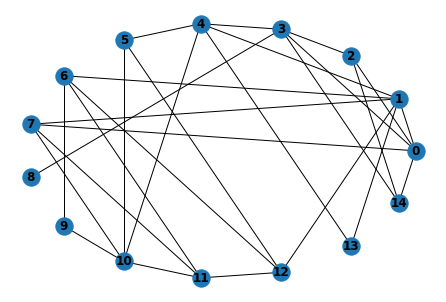

In [89]:
nx.draw_shell(g_priority, nlist = [range(node_size)], with_labels=True, font_weight='bold')

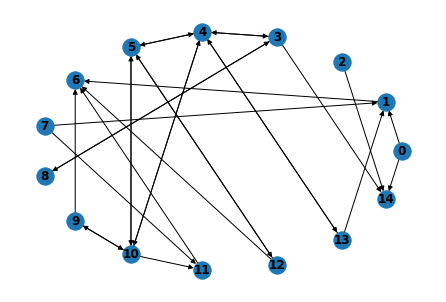

In [90]:
nx.draw_shell(g, nlist = [range(node_size)], with_labels=True, font_weight='bold')

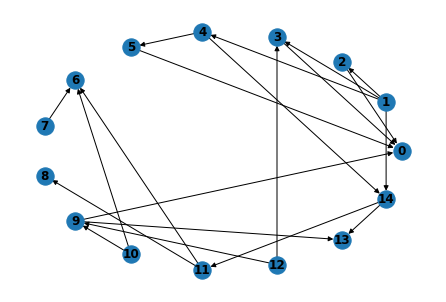

In [91]:
nx.draw_shell(g_answer, nlist = [range(node_size)], with_labels=True, font_weight='bold')

ValueError: x and y must have same first dimension, but have shapes (19,) and (0,)

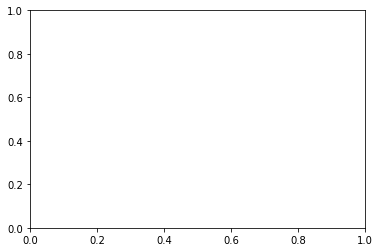

In [139]:
line1 = plt.plot(range(10,105,5), time_record[:-20], label='PC')
line2 = plt.plot(range(10,105,5), time_record_chowliu[:-20], label='PC + ChowLiu')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

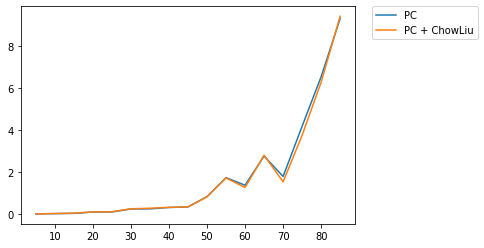

In [33]:
line1 = plt.plot(range(5,90,5), time_record[:-13], label='PC')
line2 = plt.plot(range(5,90,5), time_record_chowliu[:-14], label='PC + ChowLiu')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
np.save('PC-benchmark-CPU_range(5,155,5).npy', time_record)

In [18]:
len(range(5,155,5))

30

# Back Up

In [36]:
def partial_corr(i, j, S, C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    i : [0:p], 1st variable of interest
    j : [0:p], 2nd variable of interest
    Returns
    -------
    P : array-like, shape (2 x 2) (Pij)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    
    idx = np.zeros(p, dtype=np.bool)
    idx[S] = True
    
    beta_i = np.linalg.lstsq(C[:, idx], C[:, i], rcond=None)[0]
    beta_j = np.linalg.lstsq(C[:, idx], C[:, j], rcond=None)[0]
    
    """ ******************************************************************************
    !!! Should Implement A CUDA version, CuPy does NOT have linear regression function

    def cu_linear_regression(Y, X, w, iterations, alphaN):
        for i in range(iterations):
            w -= alphaN * np.dot(X.T, np.dot(X,w)-Y)
        return w
    ******************************************************************************
    """
    
    
    
    res_i = C[:, i] - C[:, idx].dot(beta_i)
    res_j = C[:, j] - C[:, idx].dot(beta_j)

    p_corr = sps.pearsonr(res_i, res_j)[0]
        
    return p_corr

In [209]:
(np.random.random() < s) * (0.1 + np.random() * (1 - 0.1))

TypeError: 'module' object is not callable

In [11]:
import numpy as np
node_size = 10
A = np.tril(       (0.7 - 0.2)*(np.random.random(size=(node_size, node_size))) + 0.2, -1   )
A_mask = np.random.rand(node_size) < 0.2
A *= A_mask

In [12]:
A

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.45917614, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.44206717, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.50367188, 0.        ,
        0.21738173, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [52]:
answer = pd.read_csv("edges_graph_10.txt", sep = '\t')
answer.loc[2:, 'Graph Nodes:']

2       1. X1 --> X3
3       2. X1 --> X4
4       3. X1 --> X5
5       4. X1 --> X6
6       5. X1 --> X7
7       6. X2 --> X3
8       7. X2 --> X4
9       8. X2 --> X7
10      9. X2 --> X9
11     10. X3 --> X5
12     11. X3 --> X7
13     12. X3 --> X8
14    13. X4 --> X10
15     14. X4 --> X5
16     15. X4 --> X6
17     16. X4 --> X8
18     17. X4 --> X9
19     18. X5 --> X8
20     19. X5 --> X9
21    20. X6 --> X10
22     21. X6 --> X7
23     22. X6 --> X8
24     23. X6 --> X9
25     24. X7 --> X8
26    25. X8 --> X10
Name: Graph Nodes:, dtype: object

In [37]:
a.to_numpy()

array([[ 2.6813,  1.9102, -1.2281, ...,  2.1093, -0.723 ,  0.903 ],
       [-1.8958, -0.684 ,  0.9788, ...,  0.6013,  2.0871,  0.4718],
       [ 0.5766, -3.6032,  2.0694, ..., -0.2526, -3.0346,  0.4406],
       ...,
       [ 2.1257, -0.3707,  0.2811, ...,  6.1229,  5.4526,  7.0509],
       [ 1.3592,  4.5976, -9.9959, ..., -2.5278,  4.6508, -0.6428],
       [-1.9422,  1.831 ,  1.7634, ...,  0.8022,  2.9019,  1.6214]])

In [62]:
tmp = set([1,2,3,4]) & set([3,4,5,6,7,8,9,0])
print(tmp)
print(set([3,4,5,6,7,8,9,0]) - tmp)

{3, 4}
{0, 5, 6, 7, 8, 9}
